## Fake News Detection

Import libraries

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk import word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [74]:
train = pd.read_csv('../data/fake_or_real_news_training.csv')
# the submission data has no label
submission = pd.read_csv('../data/fake_or_real_news_test.csv')

First look at data

In [40]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


We can see that two extra columns were created, X1 and X2. This is due to the fact that the title is not in quotes such that, if there is a comma in the title, it get's separated at that point and all the other column get shifted. The following cell will take care of that

In [41]:
def rearrange(df):
    for row in range(len(df)):
        if not pd.isna(df.iloc[row, 5]):
            # Concatenate according columns
            df.iloc[row, 1] = df.iloc[row, 1] + df.iloc[row, 2] + df.iloc[row, 3]
            df.iloc[row, 2] = df.iloc[row, 4]
            df.iloc[row, 3] = df.iloc[row, 5]
        elif not pd.isna(df.iloc[row, 4]):
            df.iloc[row, 1] = df.iloc[row, 1] + df.iloc[row, 2]
            df.iloc[row, 2] = df.iloc[row, 3]
            df.iloc[row, 3] = df.iloc[row, 4]
    df = df.drop(['X1', 'X2'], axis = 1)
    return df

train = rearrange(train)

In [42]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### EDA

Proportion of fake-news:

In [43]:
len(train.loc[train['label'] == 'FAKE'])/len(train)

0.4978744686171543

Explore phrase length

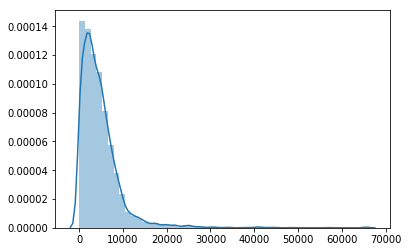

In [44]:
text_len = pd.DataFrame([len(t) for t in train.text])
sns.distplot(text_len)

The distribution is highly skewed to the right.

### Baseline

Run a baseline without further preprocessing using the countvectorizer, using the text only

Split data into train and test set

In [45]:
X_baseline, X_test_baseline, y_baseline, y_test_baseline = train_test_split(train['text'], train['label'],
                                                                            test_size = 0.2, random_state = 7)

Count-vectorize data:

In [36]:
# Initiaulize countvectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform 
count_train = count_vectorizer.fit_transform(X_baseline) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test_baseline)

Use Naive Bayes for a first classification

In [37]:
MltNB = MultinomialNB() 

In [46]:
MltNB.fit(count_train, y_baseline)
pred = MltNB.predict(count_test)
acc = accuracy_score(y_test_baseline, pred)
print("accuracy:   %0.3f" % acc)

confusion_matrix(y_test_baseline, pred, labels=['FAKE', 'REAL'])

accuracy:   0.886


array([[348,  57],
       [ 34, 361]])

### Tuning Model
1. Different Model
2. More Process on Data
3. Tuning Parameters
4. Additional thoughts: can we add another model to predicit base on news' title, then ensemble both models to make a final prediction?

TfidfVectorizer

In [69]:
# can tune max_df later
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, norm='l2')
# transform data
tfidf_train = tfidf_vectorizer.fit_transform(X_baseline)
tfidf_test = tfidf_vectorizer.transform(X_test_baseline)

In [70]:
MltNB_TFIDF = MultinomialNB(alpha=0.1) 
MltNB_TFIDF.fit(tfidf_train, y_baseline)
pred_TFIDF = MltNB_TFIDF.predict(tfidf_test)
acc_TFIDF = accuracy_score(y_test_baseline, pred_TFIDF)
print("accuracy:   %0.3f" % acc_TFIDF)

confusion_matrix(y_test_baseline, pred_TFIDF, labels=['FAKE', 'REAL'])

accuracy:   0.904


array([[347,  58],
       [ 19, 376]])

### Re-Process Data

In [84]:
def prepare_data(data):
    """
    processing data, on text and title
    """
    # fix X1 X2 issue
    data = rearrange(data)
    # tokenize the title and text
    data['title'] = data.title.apply(lambda x:" ".join(word_tokenize(x.lower())))
    data['text'] = data.text.apply(lambda x:" ".join(word_tokenize(x.lower())))
    # convert the target variable to 0 and 1
    data.label = data.label.apply(lambda x:1 if x == 'REAL' else 0)
    return data

In [182]:
# reload data
train_0 = pd.read_csv('../data/fake_or_real_news_training.csv')
train_1 = prepare_data(train_0)

In [183]:
# split data
def split_data(data, feature='text'):
    X_train, X_test, y_train, y_test = train_test_split(data[feature], data['label'],
                                                        test_size = 0.2, random_state = 7)
    return X_train, X_test, y_train, y_test

In [159]:
# vectorize
def vectorize_select(selection="tfidf", max_df=0.8):
    """
    "tfidf":"TfidVectorizer"
    "count":"CountVectorizer"
    "hash":"HashingVectorizer"
    """
    if selection == "tfidf":
        return TfidfVectorizer(stop_words='english', max_df=max_df)
    elif selection == "count":
        return CountVectorizer(stop_words='english', max_df=max_df)
    elif selection == "hash":
        return HashingVectorizer(stop_words='english')
    else:
        raise Exception("{} can't be found".format(selection))


#### Naive Bayes

In [168]:
# ti-idf vectorize MultinomialNB model
def nb_model(data,selection='tfidf',vectorize_max_df=0.8):
    # split data
    X_train, X_test, y_train, y_test = split_data(data)
    
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)

    # model 
    MltNB = MultinomialNB(alpha=0.1) 
    MltNB.fit(tfidf_train, y_train)
    pred = MltNB.predict(tfidf_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return MltNB

In [169]:
nb_model(train_1,'tfidf',0.8)

accuracy:   0.904
[[347  58]
 [ 19 376]]


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [170]:
nb_model(train_1,'hash',0.8)

accuracy:   0.904
[[347  58]
 [ 19 376]]


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [171]:
nb_model(train_1,'count',0.8)

accuracy:   0.904
[[347  58]
 [ 19 376]]


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

### Other Models


#### Random Forest

In [172]:
# ti-idf vectorize rf model
def rf_model(data,selection='tfidf',vectorize_max_df=0.8):
    # split data
    X_train, X_test, y_train, y_test = split_data(data)
    
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    
    # pipeline
    estimators = [('RF',RandomForestClassifier(random_state=666,n_estimators=100,max_depth=20))]
    pipe = Pipeline(estimators)
    param_RF = {'RF__max_depth': [20,25],
                'RF__n_estimators': [100,150]}
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(vectorize_train, y_train)

    pred = model.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model

In [173]:
rf_model(train_1,'tfidf',0.8)

accuracy:   0.916
[[380  25]
 [ 42 353]]


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=666, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'RF__max_depth': [20, 25], 'RF__n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [176]:
rf_model(train_1,'hash',0.8)

accuracy:   0.881
[[369  36]
 [ 59 336]]


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=666, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'RF__max_depth': [20, 25], 'RF__n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [177]:
rf_model(train_1,'count',0.8)

accuracy:   0.901
[[373  32]
 [ 47 348]]


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=666, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'RF__max_depth': [20, 25], 'RF__n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

#### Passive Aggressive Classifier

In [194]:
def PAC(data, selection='tfidf', vectorize_max_df=0.8, feature='text'):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature)
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    # model 
    linear_clf = PassiveAggressiveClassifier(random_state=666, max_iter=100, tol=1e-3,
                                             early_stopping=True, validation_fraction=0.1)
    linear_clf.fit(vectorize_train, y_train)
    pred = linear_clf.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return linear_clf, vectorizer

In [195]:
m_text, v_text = PAC(train_1,'tfidf')

accuracy:   0.932
[[379  26]
 [ 28 367]]


In [190]:
m = PAC(train_1,'hash')

accuracy:   0.909
[[365  40]
 [ 33 362]]


In [191]:
m = PAC(train_1,'count')

accuracy:   0.869
[[346  59]
 [ 46 349]]


### Model on Title

In [196]:
m_title, v_title = PAC(train_1, 'tfidf', feature='title')

accuracy:   0.787
[[320  85]
 [ 85 310]]


In [186]:
m = PAC(train_1, 'count', feature='title')

accuracy:   0.776
[[308  97]
 [ 82 313]]


In [187]:
m = PAC(train_1, 'hash', feature='title')

accuracy:   0.784
[[316  89]
 [ 84 311]]


1. predict base on text (train on training set, predict on the entire)
2. predict base on title (train on training set, predict on the entire)
3. add two predictions to the dataframe
4. maybe concatenate title and text?

In [197]:
# adding text based prediction to data
data_text = v_text.transform(train_1.text)
data_text_prediction = m_text.predict(data_text)
train_1['text_predict'] = data_text_prediction

In [202]:
# adding title based prediction to data
data_title = v_title.transform(train_1.title)
data_title_prediction = m_title.predict(data_title)
train_1['title_predict'] = data_title_prediction

#### Reprocess Data

In [206]:
stopwords_en = stopwords.words('english')
# define function to eliminate the stopwords
def eliminate_stopwords(wordslist):
    """
    stopwords_en is predefined outside of the function
    """
    wordslist = [i for i in wordslist if i.isalpha()]
    clean_list = [i for i in wordslist if i not in stopwords_en]
    return clean_list

In [207]:
# postag
def count_postags(words):
    tagged_words = nltk.pos_tag(words)
    num_noun = 0
    num_verb = 0
    num_adj = 0
    for word in tagged_words:
        if word[1] == 'NN':
            num_noun += 1
        elif word[1] == 'VERB':
            num_verb += 1
        elif word[1] == 'ADJ':
            num_adj += 1
    return num_noun, num_verb, num_adj


In [208]:
# detect keywords
def detect_keyword(words, keyword):
    if keyword in words:
        return 1
    else:
        return 0

In [210]:
# need one more time process to create additional features
def prepare_data2(data):
    """
    feature engineering
    """
    # tokenize the title and text
    data['title_token'] = data.title.apply(lambda x:word_tokenize(x.lower()))
    data['text_token'] = data.text.apply(lambda x:word_tokenize(x.lower()))

    # eliminate the stopwords in title and text
    data['titletoken_without_stopwords'] = data.title_token.apply(lambda x:eliminate_stopwords(x))
    data['texttoken_without_stopwords'] = data.text_token.apply(lambda x:eliminate_stopwords(x))

    # need to eliminate the punctuation as well? 
    # maybe do it with regex from the original title and text

    ## feature engineering 
    
    # find keywords
    data['trump_title'] = data.titletoken_without_stopwords.apply(lambda x:detect_keyword(x,'trump'))
    data['trump_text'] = data.texttoken_without_stopwords.apply(lambda x:detect_keyword(x,'trump'))
    
    # count the postags
    # title
    data['title_postags'] = data.titletoken_without_stopwords.apply(lambda x:count_postags(x))
    data['title_NN_count'] = data.title_postags.map(lambda x:x[0])
    data['title_VERB_count'] = data.title_postags.map(lambda x:x[1])
    data['title_ADJ_count'] = data.title_postags.map(lambda x:x[2])
    # text
    data['text_postags'] = data.texttoken_without_stopwords.apply(lambda x:count_postags(x))
    data['text_NN_count'] = data.text_postags.map(lambda x:x[0])
    data['text_VERB_count'] = data.text_postags.map(lambda x:x[1])
    data['text_ADJ_count'] = data.text_postags.map(lambda x:x[2])
    
    
    
    # create new features describe the length of the title and text, counting by words
    # also maybe try with counting by letters
    # and shall treat them as categorical variables group up with factor levels 
    data['title_length'] = data.title_token.apply(lambda x:len(x))
    data['text_length'] = data.text_token.apply(lambda x:len(x))
    # also highlight the keywords maybe?
    
    
    
    return data

In [215]:
train_2 = prepare_data2(train_1)
train_3 = train_2[['label','text_predict','title_predict','trump_title', 'trump_text',
                   'title_NN_count', 'title_VERB_count','title_ADJ_count', 
                   'text_NN_count', 'text_VERB_count','text_ADJ_count', 
                   'title_length', 'text_length']]

,label,text_predict,title_predict,trump_title,trump_text,title_NN_count,title_VERB_count,title_ADJ_count,text_NN_count,text_VERB_count,text_ADJ_count,title_length,text_length
0,0,0,0,0,1,2,0,0,253,0,0,7,1473
1,0,0,0,1,1,8,0,0,93,0,0,16,516
2,1,1,1,0,0,3,0,0,85,0,0,9,485
3,0,0,0,0,1,4,0,0,78,0,0,18,497
4,1,1,1,0,1,2,0,0,54,0,0,10,376


In [223]:
# ti-idf vectorize rf model
def rf_model_2(data,features=features):
    # split data
    X_train, X_test, y_train, y_test = split_data(data,feature=features)
    
    # pipeline
    estimators = [('RF',RandomForestClassifier(random_state=666))]
    pipe = Pipeline(estimators)
    param_RF = {'RF__max_depth': [20,25],
                'RF__n_estimators': [150,200]}
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))

    return model

In [229]:
features = ['text_predict','title_predict',
            'trump_title', 'trump_text',
#             'title_NN_count', 'title_VERB_count','title_ADJ_count', 
#             'text_NN_count', 'text_VERB_count','text_ADJ_count', 
#             'title_length', 'text_length'
           ]
m = rf_model_2(train_3,features)

accuracy:   0.932
[[379  26]
 [ 28 367]]


In [85]:
def prepare_data(data):
    """
    preprocessing + feature engineering
    """
    # tokenize the title and text
    data['title_token'] = data.title.apply(lambda x:word_tokenize(x.lower()))
    data['text_token'] = data.text.apply(lambda x:word_tokenize(x.lower()))
    # convert the target variable to 0 and 1
    data.label = data.label.apply(lambda x:1 if x == 'REAL' else 0)
    
    # eliminate the stopwords in title and text
    data['titletoken_without_stopwords'] = data.title_token.apply(lambda x:eliminate_stopwords(x))
    data['texttoken_without_stopwords'] = data.text_token.apply(lambda x:eliminate_stopwords(x))
    # drop the redundent features
    data = data.drop(['text','title'],axis=1)
    # need to eliminate the punctuation as well? 
    # maybe do it with regex from the original title and text

    ## feature engineering 
    
    # find keywords
    data['trump_title'] = data.titletoken_without_stopwords.apply(lambda x:detect_keyword(x,'trump'))
    data['trump_text'] = data.texttoken_without_stopwords.apply(lambda x:detect_keyword(x,'trump'))
    
    # count the postags
    # title
    data['title_postags'] = data.titletoken_without_stopwords.apply(lambda x:count_postags(x))
    data['title_NN_count'] = data.title_postags.map(lambda x:x[0])
    data['title_VERB_count'] = data.title_postags.map(lambda x:x[1])
    data['title_ADJ_count'] = data.title_postags.map(lambda x:x[2])
    # text
    data['text_postags'] = data.texttoken_without_stopwords.apply(lambda x:count_postags(x))
    data['text_NN_count'] = data.text_postags.map(lambda x:x[0])
    data['text_VERB_count'] = data.text_postags.map(lambda x:x[1])
    data['text_ADJ_count'] = data.text_postags.map(lambda x:x[2])
    
    
    
    # create new features describe the length of the title and text, counting by words
    # also maybe try with counting by letters
    # and shall treat them as categorical variables group up with factor levels 
    data['title_length'] = data.title_token.apply(lambda x:len(x))
    data['text_length'] = data.text_token.apply(lambda x:len(x))
    # also highlight the keywords maybe?
    
    
    
    return data

In [86]:
train_df = prepare_data(train)

In [89]:
def splitdata(data, cols):
    """
    cols: a list of columns names to use
    """
    features = data[cols]
    target = data.label
    # first split into (train+test) and for holdout
    TrainingSetX, X_holdout, TrainingSetY, y_holdout = train_test_split(features, target, 
                                                    test_size=0.10, stratify=target, 
                                                    random_state=666)
    # split (train+test) into train and test
    X_train, X_test, y_train, y_test = train_test_split(TrainingSetX, TrainingSetY, 
                                                test_size=0.20, stratify=TrainingSetY, 
                                                random_state=666)
    # train and test use for modeling, holdout use for validating the model
    print("spliting the data......")
    print("shape of train set: ", X_train.shape)
    print("shape of test set: ", X_test.shape)
    print("shape of holdout set: ", X_holdout.shape)
    
    return X_train, y_train, X_test, y_test, X_holdout, y_holdout

In [31]:
cols2model = ['title_token', 'text_token', 'titletoken_without_stopwords', 
              'texttoken_without_stopwords', 'title_length']
x1,y1,x2,y2,x3,y3 = splitdata(train_df, cols = cols2model)

spliting the data......
shape of train set:  (2879, 5)
shape of test set:  (720, 5)
shape of holdout set:  (400, 5)


In [34]:
# random forest classifier
def model_rf(data,cols2model):
    # split data
    X_train, y_train, X_test, y_test, X_holdout, y_holdout = splitdata(train_df, cols = cols2model)
    print('features for modeling :',X_train.columns.tolist())
    # identify the categorical features and the numerical features
    categorical_features = X_train.dtypes == 'category'
    numerical_features = ~categorical_features
    # pipeline
    print('building up pipeline......')
    estimators = [   
                    ('ctf',ColumnTransformer([
                                ('scale',StandardScaler(),
                                         numerical_features),
                                ('enc',OneHotEncoder(categories='auto',handle_unknown='ignore'),
                                         categorical_features),
                                            ])
                    ),
#                     ('poly', PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)),
                    ('RF',RandomForestClassifier(random_state=666,n_estimators=170,max_depth=22,n_jobs=-1))
                ]
    pipe = Pipeline(estimators)
    
    print('training the model......')
    model = pipe.fit(X_train,y_train)
    
    print('training is done')
    score_train = model.score(X_train,y_train) 
    score_test = model.score(X_test,y_test) 
    score_Holdout = model.score(X_holdout,y_holdout) 
    
    print('training dataset mode1 is: %s'%(str(score_train1)))   
    print('test dataset model is: %s'%(str(score_test1)))
    print('Holdout dataset model1 is: %s'%(str(score_H1)))
    
    # in case needs to use the data to do some visualization or some other metrics
    data_pack = (X_train, y_train, X_test, y_test, X_holdout, y_holdout)
    return model, data_pack

In [7]:
sample = train.copy()